# ***QTM 350 Final Project***
### Olivia Song, Elizabeth Bryant, Betty Li, and Aaron Leonard
![Climate](https://www.noaa.gov/sites/default/files/styles/scale_crop_1120x534/public/thumbnails/image/Photo%20collage-climate%20scenarios-global%20climate%20reports-NOAA%20image-landscapes.jpg?itok=rcowMNf5)

For our Data Science Capstone, our group analyzed NOAA Global Historical Climatology Network Daily data from the Registry of Open Data on AWS (https://registry.opendata.aws/noaa-ghcn/). We found this dataset interesting because climate change has been a major topic in the news for the past few years. Also, weather data is faily easy to work with since all the variables are familiar. This dataset contains daily observations for precipitation, temperature, snow depth, and time of observation from multiple resources since 1763. We decided to focus on data from 2019 and 1919, since 2019 is the most current and complete and 1919 is exactly 100 years before. We can compare the data to see how climate has changed over the years. Our work can be found at https://github.com/miaowu128/QTM350FinalProject.git.

We began by looking at the documentation included on the Open Data Registry (https://docs.opendata.aws/noaa-ghcn-pds/readme.html). The readme file gave us insight on the variables we would be looking at. Dr. Jacobson also helped us research some other published notebooks that used the data to see if we could build off of previous work. These were great examples;however, the first notebook used a different file than the one we chose and the second was used to demonstrate how to use various python packages. 

### *Notebook Examples*
- https://livebook.manning.com/book/the-quick-python-book-third-edition/case-study/1
- https://www.kaggle.com/kerneler/starter-aws-open-source-weather-4e419ab3-9

# ***Data Architecture***
Throughout this semester we have learned about many AWS services that can be useful for running big data. Some of the services we used for our project are: Registry of Open Data, s3, EC2 instance, and SageMaker. Using draw.io, we created a diagram to show our workflow.
![Data Architecture](QTM350_FinalProject.png)

# ***Cleaning & Analysis***

## Elizabeth

First, we started by accessing the data from the Open Data Registry using the Amazon Resource Name and creating our own s3 bucket. We used the exploring-data notebook from the aws-open-data-analytics-notebooks repository to set up our project (https://github.com/aws-samples/aws-open-data-analytics-notebooks).

In [1]:
# Setting up environment
import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown

In [2]:
# Using boto3 to access s3 API
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [3]:
# Creating a unique s3 bucket
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

#### Note
Each group member made their own s3 bucket to work with since s3 bucket names have to be unique universally. This unique bucket is useful for the user to save the data their working with and access it later.

In [4]:
create_bucket('open-data-analytics-noaa')

ERROR:root:An error occurred (BucketAlreadyExists) when calling the CreateBucket operation: The requested bucket name is not available. The bucket namespace is shared by all users of the system. Please select a different name and try again.


'Bucket open-data-analytics-noaa could not be created.'

In [5]:
# List bucket to confirm that it is created
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

In [6]:
list_buckets(match='noaa')

Existing buckets containing "noaa" string:
  open-data-analytics-noaa


In [7]:
# List bucket contents: Allows us to access and see the contents of the bucket that contains the data we want
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [ ]:
# Lists the files in the NOAA Global Historical Climatology Network Daily data
list_bucket_contents(bucket='noaa-ghcn-pds', match='.csv', size_mb= 1000)

In [9]:
# Previewing the csv files that contain the data
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows, header = None)
    return data

The data we chose was from 2019 and 1919, so we can compare the climate 100 years apart. The `rows` argument allows us to set the number of rows we would like to see in the preview. These Open Data Registry datasets can contain millions of rows, so this argument is very useful to see a preview of what we're analyzing.

In [12]:
df_2019 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/2019.csv', rows = 1000)

In [69]:
df_1919 = preview_csv_dataset(bucket='noaa-ghcn-pds', key='csv/1919.csv', rows = 1000)

Now that we have chosen our datasets, we can copy our file into the bucket we created earlier.

In [16]:
# Check and see if file exists in the bucket we created earlier. Then copy the data from NOAA into our own bucket
def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

In [18]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/2019.csv',to_bucket='open-data-analytics-noaa', to_key='NOAA_2019.csv')

File NOAA_2019.csv saved to S3 bucket open-data-analytics-noaa


In [71]:
copy_among_buckets(from_bucket='noaa-ghcn-pds', from_key='csv/1919.csv',to_bucket='open-data-analytics-noaa', to_key='NOAA_1919.csv')

File NOAA_1919.csv saved to S3 bucket open-data-analytics-noaa


To confirm that the files were copied over, I went back to my s3 to make sure the files were in the bucket. As you can see the 2019 file, is 1.1 GB which is HUGE. This is why we access s3 buckets for data instead of saving the files onto our device. Downloading files that size are sometimes too big to work with on our own machines. 
![s3](NOAA_s3.png)

To begin cleaning our data, you can see that our data does not have column names. The documentation lists what each column means (https://docs.opendata.aws/noaa-ghcn-pds/readme.html). We can begin by assigning column names to make it easier to read.

In [ ]:
#Checking to see what columns look like
df_2019.head()

#Renaming Columns
df_2019.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

#Checking to see new columns
df_2019

In [ ]:
#Checking to see what columns look like
df_1919.head()

#Renaming Columns
df_1919.columns = ["ID","Date","Element","Element_Value","MFlag","QFlag","SFlag","Obs_Time"]

#Checking to see new columns
df_1919

Great! We have real columns now. The 'Element' column is all mixed up with different weather descriptions. With each element input, there is a value or measurement for that element in the Element_Value column. I think it would be interesting to see the averages for each element for the year of 2019, by using the `groupby` and `.mean()` argument.

In [40]:
df_2019_Element = df_2019.groupby(by = ['Element'])['Element_Value'].mean()
df_2019_Element

Element
AWDR     168.000000
AWND      34.666667
EVAP       0.000000
MNPN       0.000000
MXPN      72.000000
PGTM    1505.250000
PRCP      59.368056
SN32      17.000000
SNOW      14.269231
SNWD     109.115789
SX32      28.000000
TAVG       9.025641
TMAX      67.801527
TMIN     -39.985075
TOBS     -41.043478
WDF2     147.692308
WDF5     248.333333
WDFG      26.666667
WDMV      18.000000
WESD     660.200000
WESF      58.100000
WSF2      75.538462
WSF5     104.272727
WSFG     412.000000
WSFI      49.000000
WT01       1.000000
WT02       1.000000
WT08       1.000000
Name: Element_Value, dtype: float64

In [73]:
df_1919_Element = df_1919.groupby(by = ['Element'])['Element_Value'].mean()
df_1919_Element

Element
PRCP     31.899563
SNOW      7.007874
SNWD    141.482143
TAVG   -175.500000
TMAX     23.310606
TMIN    -87.940299
TOBS     -6.304878
WT04      1.000000
WT16      1.000000
Name: Element_Value, dtype: float64

The five main elements are precipitation(PRCP), snowfall(SNOW), snow depth(SNWD), maximum temperature(TMAX), and minimum temperature(TMIN). However, there are different subcategories of each, and these descriptions can be found in the documention. 

The list of outputs is kind of difficult to look at, so it would be better to read in a data visualization.

Text(0.5, 1.0, 'Average Measure of Elements - 2019')

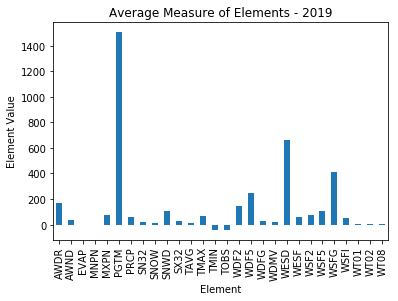

In [67]:
plot = df_2019_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 2019')

Peak Gust Time(PGTM) has the highest average measurement of 1505.250000, which is measured as time in hours and minutes.The lowest average measurement is Temperature at the Time of Observation(TOBS) at -41.043478, which is measured in celsius.

Text(0.5, 1.0, 'Average Measure of Elements - 1919')

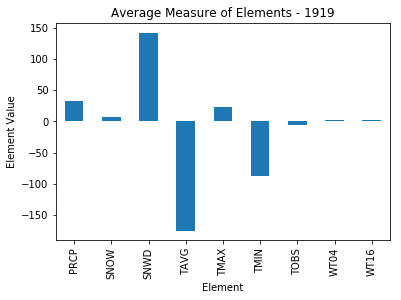

In [74]:
plot = df_1919_Element.plot.bar(x='Element', y = 'Element_Value',bottom = 0.5)
plot.set_ylabel('Element Value')
plot.set_title('Average Measure of Elements - 1919')

The Peak Gust Time(PGTM) was not recorded in 1919. This could be because over the years data collection has become more precise and has extended to greater categories. However we can compare the Temperature at the Time of Observation(TOBS). In 1919, the average for TOBS was -6.304878 celsius. This a 34.7386 degree difference between 2019 and 1919, which shows that weather has greatly changed over the years. 